<a href="https://colab.research.google.com/github/JeoungHojin/image_process/blob/main/codec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이미지 로드 성공: 531x709


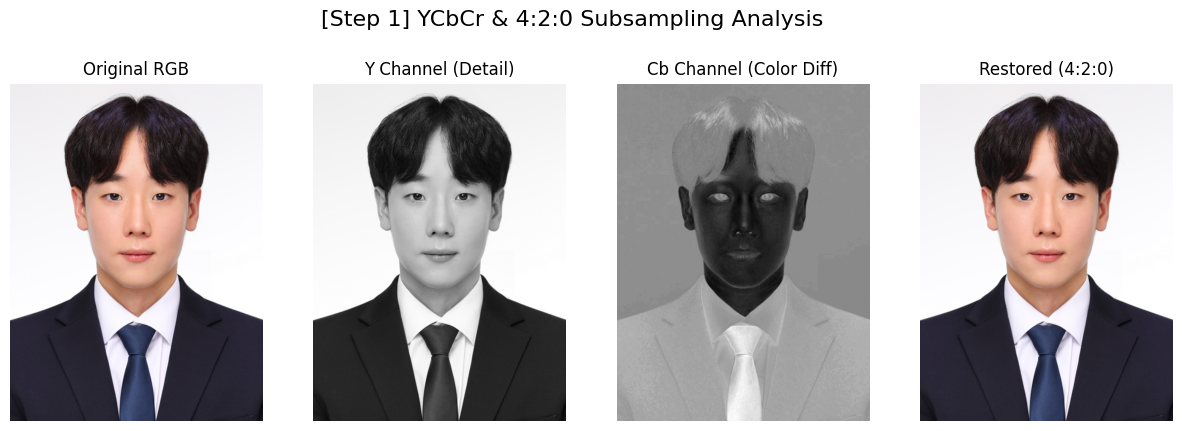

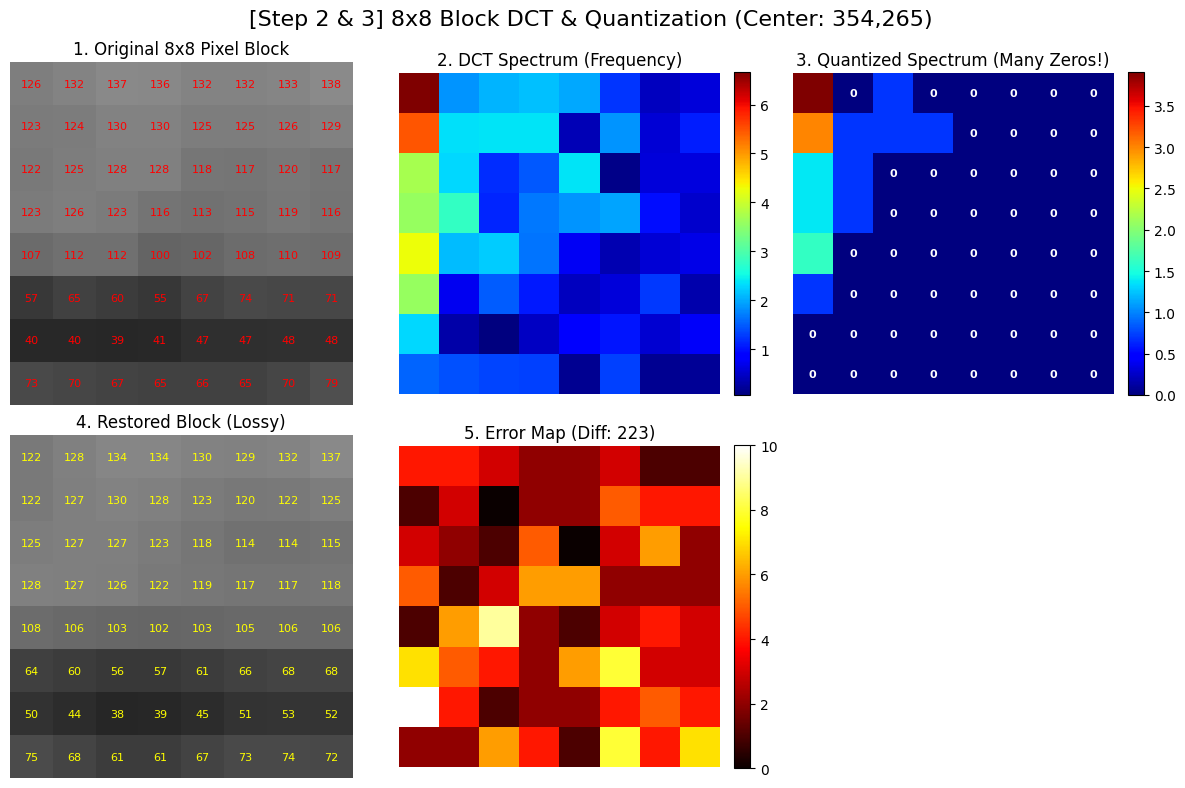

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_compression_steps(img_path):
    # 1. 이미지 로드 (Gray & Color)
    img = cv2.imread(img_path)
    if img is None:
        print("이미지를 찾을 수 없습니다.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape

    print(f"이미지 로드 성공: {w}x{h}")

    # =========================================================
    # [cite_start][STEP 1] YCbCr 변환 & 4:2:0 시각화 [cite: 337-358]
    # =========================================================
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(img_ycbcr)

    # 4:2:0 시뮬레이션 (Cb, Cr을 1/2로 축소 후 다시 확대)
    # 인터폴레이션으로 뭉개짐 효과 확인
    Cb_down = cv2.resize(Cb, (w // 2, h // 2), interpolation=cv2.INTER_AREA)
    Cr_down = cv2.resize(Cr, (w // 2, h // 2), interpolation=cv2.INTER_AREA)

    Cb_restored = cv2.resize(Cb_down, (w, h), interpolation=cv2.INTER_LINEAR)
    Cr_restored = cv2.resize(Cr_down, (w, h), interpolation=cv2.INTER_LINEAR)

    # 결과 합치기
    restored_ycbcr = cv2.merge([Y, Cr_restored, Cb_restored])
    restored_rgb = cv2.cvtColor(restored_ycbcr, cv2.COLOR_YCrCb2RGB)

    # --- 시각화 1: YCbCr ---
    plt.figure(figsize=(15, 5))
    plt.suptitle("[Step 1] YCbCr & 4:2:0 Subsampling Analysis", fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original RGB")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(Y, cmap='gray')
    plt.title("Y Channel (Detail)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(Cb, cmap='gray') # 색차 정보는 흑백으로 보면 대비가 보임
    plt.title("Cb Channel (Color Diff)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(restored_rgb)
    plt.title("Restored (4:2:0)")
    plt.axis('off')
    plt.show()

    # =========================================================
    # [cite_start][STEP 2] DCT & Quantization (8x8 블록 히트맵) [cite: 359-406]
    # =========================================================
    # 디테일이 많은 부분(눈, 머리카락 등)을 자르기 위해 중앙 부분 선택
    cr, cc = h // 2, w // 2
    block = np.float32(img_gray[cr:cr+8, cc:cc+8])

    # 1. DCT 수행
    dct_block = cv2.dct(block)

    # 2. 양자화 (Quantization)
    # [cite_start]표준 Luminance Q-Table [cite: 193-194]
    Q_table = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ], dtype=np.float32)

    # 양자화 수행 (나누고 반올림 -> 정보 손실 발생!)
    quantized = np.round(dct_block / Q_table)

    # 3. 역과정 (복원)
    dequantized = quantized * Q_table
    idct_block = cv2.idct(dequantized)
    idct_block = np.clip(idct_block, 0, 255).astype(np.uint8)

    # --- 시각화 2: DCT & Quantization ---
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"[Step 2 & 3] 8x8 Block DCT & Quantization (Center: {cr},{cc})", fontsize=16)

    # 1. 원본 블록 (픽셀)
    plt.subplot(2, 3, 1)
    plt.imshow(block, cmap='gray', vmin=0, vmax=255)
    plt.title("1. Original 8x8 Pixel Block")
    # 픽셀 값 표시
    for y in range(8):
        for x in range(8):
            plt.text(x, y, int(block[y, x]), ha='center', va='center', color='red', fontsize=8)
    plt.axis('off')

    # 2. DCT 스펙트럼 (히트맵)
    plt.subplot(2, 3, 2)
    # 로그 스케일로 봐야 차이가 보임
    plt.imshow(np.log(np.abs(dct_block) + 1), cmap='jet')
    plt.title("2. DCT Spectrum (Frequency)")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    # 3. 양자화 후 스펙트럼 (0이 된 것 확인)
    plt.subplot(2, 3, 3)
    plt.imshow(np.log(np.abs(quantized) + 1), cmap='jet') # 0은 파란색으로 보임
    plt.title("3. Quantized Spectrum (Many Zeros!)")
    plt.colorbar(fraction=0.046, pad=0.04)
    # 0 값 표시
    for y in range(8):
        for x in range(8):
            val = int(quantized[y, x])
            if val == 0:
                plt.text(x, y, "0", ha='center', va='center', color='white', fontsize=8, fontweight='bold')
    plt.axis('off')

    # 4. 복원된 블록 (손실 확인)
    plt.subplot(2, 3, 4)
    plt.imshow(idct_block, cmap='gray', vmin=0, vmax=255)
    plt.title("4. Restored Block (Lossy)")
    # 픽셀 값 표시
    for y in range(8):
        for x in range(8):
            plt.text(x, y, int(idct_block[y, x]), ha='center', va='center', color='yellow', fontsize=8)
    plt.axis('off')

    # 5. 오차 (Noise) 확인
    plt.subplot(2, 3, 5)
    diff = np.abs(block - idct_block)
    plt.imshow(diff, cmap='hot')
    plt.title(f"5. Error Map (Diff: {np.sum(diff):.0f})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
img_path = '/content/drive/MyDrive/사진/1611a.jpg'
visualize_compression_steps(img_path)